In [110]:
import os.path as op
import warnings
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm

%matplotlib inline
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["xtick.major.width"] = 0.8
mpl.rcParams["ytick.major.width"] = 0.8
colors = [
    "1f77b4",
    "d62728",
    "2ca02c",
    "ff7f0e",
    "9467bd",
    "8c564b",
    "e377c2",
    "7f7f7f",
    "bcbd22",
    "17becf",
]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler("color", colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.formatter.offset_threshold"] = 2
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.labelpad"] = 8
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["legend.loc"] = "upper right"
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.titlesize"] = 16
mpl.rcParams["figure.figsize"] = (10, 4)
mpl.rcParams["figure.subplot.wspace"] = 0.25
mpl.rcParams["figure.subplot.hspace"] = 0.25
mpl.rcParams["savefig.format"] = "pdf"
mpl.rcParams["pdf.fonttype"] = 42
font = {"tick": 6, "label": 7, "title": 8}

In [45]:
proj_dir = "/Users/dschonhaut/box/projects/leads_tau_spread"

# Load FreeSurfer ROI labels.
fsrois = pd.read_excel(
    op.join(proj_dir, "data", "FTP_PETCore_Analysis_2022-12-15.xlsx"), "fsrois"
)

# Load subject demographic and tau-PET ROI SUVR values.
tau_rois = pd.read_excel(
    op.join(proj_dir, "data", "FTP_PETCore_Analysis_2022-12-15.xlsx"), "data"
)
tau_rois = tau_rois.sort_values(["subj", "visit"])
rois_in_order = ["{}_{}".format(hem.lower(), region.lower()) for (hem, region) in fsrois.sort_values('order')[['hem', 'region']].values]

print("tau_rois: {}".format(tau_rois.shape))

tau_rois: (641, 163)


In [57]:
cols = {
    "demo": [
        x
        for x in tau_rois.columns
        if np.all((not x.endswith("_suvr"), not x.endswith("_vol")))
    ],
    "suvr": [x for x in tau_rois.columns if x.endswith("_suvr")],
    "vol": [x for x in tau_rois.columns if x.endswith("_vol")],
}

cols["suvr"] = ["{}_suvr".format(x) for x in rois_in_order]
cols["vol"] = ["{}_vol".format(x) for x in rois_in_order]

for k, v in cols.items():
    print("{}: {} columns".format(k, len(v)))

demo: 19 columns
suvr: 72 columns
vol: 72 columns


In [38]:
warnings.filterwarnings("ignore")

# W-score values against the control group.
tau_rois_w = tau_rois.loc[:, cols["demo"]].copy()
cols_to_wscore = cols["suvr"] + cols["vol"]

# Find baseline visits for controls.
idx = tau_rois.query("(dx=='CON') & (visit==1)").index

params = {}
for col in cols_to_wscore:
    # Regress column values against control age and sex.
    mod = sm.OLS(
        endog=tau_rois.loc[idx, col],
        exog=sm.add_constant(tau_rois.loc[idx, ["age_at_baseline_pet", "sex_m"]]),
    )
    res = mod.fit()

    # Log the model results.
    params[col] = {
        "nobs": idx.size,
        "r": np.sqrt(res.rsquared),
        "icpt": res.params["const"],
        "beta_age": res.params["age_at_baseline_pet"],
        "t_age": res.tvalues["age_at_baseline_pet"],
        "p_age": res.pvalues["age_at_baseline_pet"],
        "beta_sex": res.params["sex_m"],
        "t_sex": res.tvalues["sex_m"],
        "p_sex": res.pvalues["sex_m"],
        "mean_resid": np.mean(res.resid),
        "std_resid": np.std(res.resid),
    }

    # Predict test score from age for all subjects (controls + patients).
    resid = tau_rois[col] - res.predict(
        exog=sm.add_constant(tau_rois[["age_at_baseline_pet", "sex_m"]])
    )

    # Z-score the residuals to obtain W-scores. Mean and standard deviation
    # W-score in the control group should be 0 and 1, respectively.
    _mean = params[col]["mean_resid"]  # should be 0
    _std = params[col]["std_resid"]
    tau_rois_w.loc[:, col] = (resid - _mean) / _std

# Calculate the average tau-PET W-score across regions in each subject.
tau_rois_w["suvr_all_unweighted"] = tau_rois_w.loc[:, cols["suvr"]].mean(axis=1).values
tau_rois_w["suvr_all_weighted"] = np.sum(tau_rois_w.loc[:, cols["suvr"]].values * tau_rois.loc[:, cols["vol"]].values, axis=1) / tau_rois.loc[:, cols["vol"]].sum(axis=1).values

# Check that all W-score column means are 0 and stdevs are 1 for the controls.
print('Check {} W-score columns in the controls...'.format(len(cols_to_wscore)),
      'All means are 0 : {}'.format(np.allclose([0], [np.max(np.abs(np.mean(tau_rois_w.loc[idx, cols_to_wscore], 0).values))])),
      'All stds are 1  : {}'.format(np.allclose([1], [np.max(np.abs(np.std(tau_rois_w.loc[idx, cols_to_wscore], 0).values))])),
      sep='\n')

warnings.resetwarnings()

Check 144 W-score columns in the controls...
All means are 0 : True
All stds are 1  : True


In [116]:
tau_rois_w['dx'].unique()

array(['CON', 'EOAD', 'EOnonAD'], dtype=object)

In [139]:
# Rank subjects in each diagnostic group by their mean baseline tau-PET W-score across regions.
tau_rois_w['subj_order_suvr_all'] = np.nan
# for dx in tau_rois_w['dx'].unique():
for dx in ['EOAD']:
    _idx = tau_rois_w.query("(dx=='{}') & (pet_visits>1) & (visit==1)".format(dx)).index
    subjs_in_order = tau_rois_w.loc[_idx, :].sort_values("suvr_all_unweighted")["subj"].tolist()
    _idx = tau_rois_w.query("(dx=='{}') & (pet_visits>1)".format(dx)).index
    tau_rois_w.loc[_idx, 'subj_order_suvr_all'] = tau_rois_w.loc[_idx, 'subj'].apply(lambda x: subjs_in_order.index(x))
    
# Re-sort subjects.
tau_rois_w = tau_rois_w.sort_values(['dx', 'subj_order_suvr_all', 'visit']).reset_index(drop=True)

In [138]:
tau_rois_w['pet_visits'].max()

4

In [141]:
tau_rois_w.loc[_idx, :]

(305, 164)

In [150]:
# Make tau-PET W-score matrices (subj x region)
wscore_mats = {}
keep_cols = ['subj_order_suvr_all'] + cols['suvr']
# for grp, df in tau_rois_w.groupby(['dx', 'visit']):
#     wscore_mats[grp] = df[keep_cols].values   

wscore_mats[('EOAD', 1)] = tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==1)").sort_values('subj_order_suvr_all')[keep_cols].values
wscore_mats[('EOAD', 2)] = tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==2)").sort_values('subj_order_suvr_all')[keep_cols].values
wscore_mats[('EOAD', 3)] = tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==3)").sort_values('subj_order_suvr_all')[keep_cols].values
wscore_mats[('EOAD', 4)] = tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==4)").sort_values('subj_order_suvr_all')[keep_cols].values

In [152]:
wscore_mats[('EOAD', 1)].shape

(129, 73)

In [154]:
print(np.max([len(wscore_mats[('EOAD', visit)]) for visit in range(1, 5)]),
      np.max([np.max(wscore_mats[('EOAD', visit)][:, 1:]) for visit in range(1, 5)]))

129 47.13431882276412


In [163]:
fig_dir = op.join(proj_dir, 'figs')

'/Users/dschonhaut/box/projects/leads_tau_spread/figs'

In [168]:
mat.min(), mat.max()

(-10.16443447301154, 21.447109637416943)

In [176]:
dat[ii, 0]

NameError: name 'dat' is not defined

In [185]:
wscore_mats[(dx, 3)][:, 0].astype(int).tolist()

[0,
 1,
 3,
 5,
 6,
 10,
 14,
 18,
 20,
 21,
 27,
 29,
 32,
 33,
 35,
 44,
 50,
 66,
 75,
 77,
 78,
 79,
 80,
 82,
 83,
 90,
 91,
 93,
 94,
 100,
 103,
 104,
 106,
 108,
 113,
 115,
 118,
 121]

In [192]:
keep_rows = wscore_mats[(dx, 3)][:, 0].astype(int).tolist()
mat = np.zeros(wscore_mats[(dx, 1)].shape) * np.nan
mat[keep_rows, :] = wscore_mats[(dx, 3)]
mat -= wscore_mats[(dx, 1)]

In [194]:
np.nanmin(mat), np.nanmax(mat)

(-6.832102939350513, 15.819015543887991)

In [175]:
v1 = np.zeros(wscore_mats[(dx, 1)].shape) * np.nan
v3 = np.zeros(wscore_mats[(dx, 1)].shape) * np.nan

v3 = wscore_mats[(dx, 3)] - wscore_mats[(dx, 1)]
for ii in wscore_mats[(dx, 3)][:, 0]:
    mat[dat[ii, 0], :] = dat[ii, :]

ValueError: operands could not be broadcast together with shapes (38,73) (129,73) 

Saved /Users/dschonhaut/box/projects/leads_tau_spread/figs/FTP_ROI_W-scores_EOAD_Visit3_129subjs.png


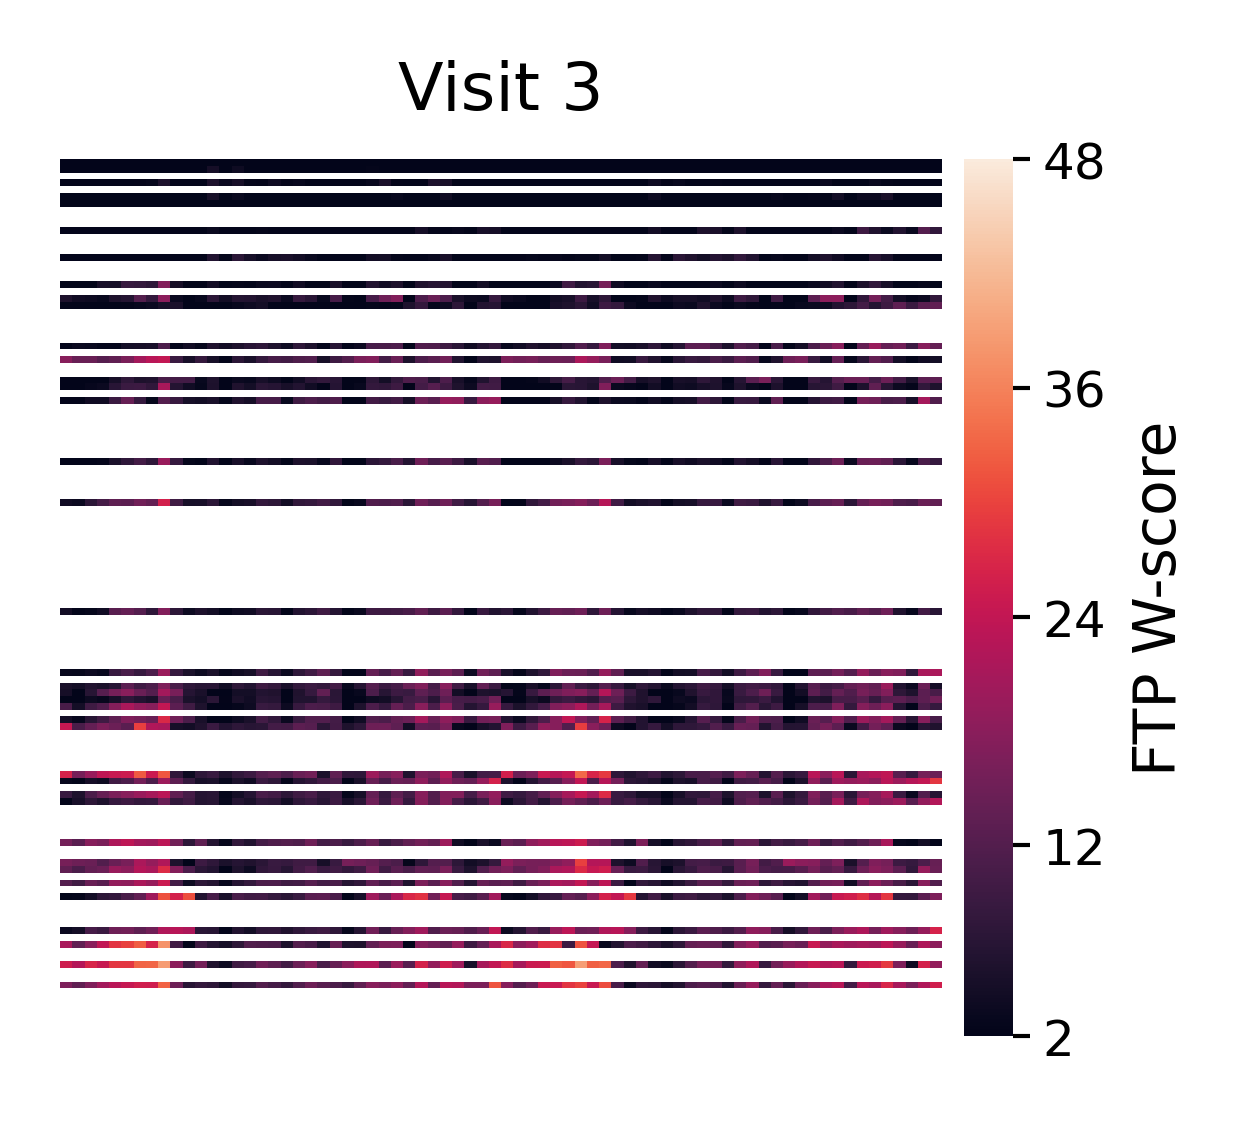

In [201]:
dx = 'EOAD'
# visit = 2
# mat = wscore_mats[(dx, visit)]

visit = 3
keep_rows = wscore_mats[(dx, 3)][:, 0].astype(int).tolist()
mat = np.zeros(wscore_mats[(dx, 1)].shape) * np.nan
mat[keep_rows, :] = wscore_mats[(dx, 3)]

vmin = 2
vmax = 48
cbar_ticks = [2, 12, 24, 36, 48]
cmap = 'rocket'

# visit = '2 - 1'
# mat = wscore_mats[(dx, 2)] - wscore_mats[(dx, 1)]

# visit = '3 - 1'
# keep_rows = wscore_mats[(dx, 3)][:, 0].astype(int).tolist()
# mat = np.zeros(wscore_mats[(dx, 1)].shape) * np.nan
# mat[keep_rows, :] = wscore_mats[(dx, 3)]
# mat -= wscore_mats[(dx, 1)]

# vmin = -22
# vmax = 22
# cbar_ticks = [-22, -11, 0, 11, 22]
# cmap = 'RdBu_r'

colws = {1: 2.05, 2: 3.125, 3: 6.45}
grid_shp = [50, 54]
figsize = (colws[1], colws[1] * (grid_shp[0]/grid_shp[1]))
dpi = 600
ticklen = 2
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
cbar_label = 'FTP W-score'
nsubjs = mat.shape[0]
fig_title = 'Visit {}'.format(visit)
background_color = 'w'
savefig = 0
overwrite = 1
# ---------------------

plt.close('all')
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=50, colspan=50),
      plt.subplot2grid(grid_shp, (0, 51), rowspan=50, colspan=3)]

iax = 0
_ax = ax[iax]                  
_ax = sns.heatmap(mat[:, 1:], vmin=vmin, vmax=vmax, ax=_ax, cbar=True, cbar_ax=ax[iax+1], cmap=cmap)

cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=ticklen, width=tickwidth, pad=tickpad)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticks)
if cbar_label is not None:
    cbar.set_label(cbar_label, fontsize=font['label'], labelpad=labelpad)
_ax.set_facecolor(background_color)
# _ax.invert_yaxis()
_ax.set_xticks([])
_ax.set_yticks([])
_ax.set_title(fig_title, fontsize=font['title'])

if savefig:
    filename = op.join(fig_dir, "FTP_ROI_W-scores_{}_Visit{}_{}subjs.png".format(dx, str(visit).replace(' ', ''), nsubjs))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))

In [6]:
tau_rois_w.loc[tau_rois.query("(dx=='EOAD') & (visit==1)").index, cols["suvr"]].mean(
    axis=0
).sort_values()

l_rostralanteriorcingulate_suvr     2.356529
r_hippocampus_suvr                  2.391099
r_rostralanteriorcingulate_suvr     2.533800
l_hippocampus_suvr                  2.615459
r_temporalpole_suvr                 3.236199
                                     ...    
l_superiorparietal_suvr            13.044196
r_inferiorparietal_suvr            13.528589
r_supramarginal_suvr               13.721827
r_caudalmiddlefrontal_suvr         14.721389
l_caudalmiddlefrontal_suvr         16.507058
Length: 72, dtype: float64

In [7]:
tau_rois_w.loc[tau_rois.query("(dx=='EOAD') & (visit==1)").index, cols["vol"]].mean(
    axis=0
).sort_values()

l_inferiorparietal_vol           -1.781068
r_inferiorparietal_vol           -1.712836
l_amygdala_vol                   -1.616274
l_middletemporal_vol             -1.491558
r_bankssts_vol                   -1.414701
                                    ...   
l_pericalcarine_vol               0.254281
l_paracentral_vol                 0.258976
r_rostralanteriorcingulate_vol    0.297397
r_caudalanteriorcingulate_vol     0.374722
r_frontalpole_vol                 0.597365
Length: 72, dtype: float64

In [11]:
tau_rois.insert(1, "tracer", "ftp")
rename_cols = {
    "ID": "subj",
    "FTPPET_date": "scan_date",
    "ImageID": "image_id",
    "CohortAssgn": "dx",
}

,ID,FTPPET_Date,ImageID,CohortAssgn,ScalingFactor_InfCerebGray,ScalingFactor_ErodedWM,Assigned_MRIBASED_MetaROI_ADNIcutoff_1p2,MetaROI_MRIBASED_SUVR,Braak_1_MRIBASED_SUVR,Braak_12_MRIBASED_SUVR,...,ctx_rh_rostralanteriorcingulate_ClustSize,ctx_rh_rostralmiddlefrontal_ClustSize,ctx_rh_superiorfrontal_ClustSize,ctx_rh_superiorparietal_ClustSize,ctx_rh_superiortemporal_ClustSize,ctx_rh_supramarginal_ClustSize,ctx_rh_frontalpole_ClustSize,ctx_rh_temporalpole_ClustSize,ctx_rh_transversetemporal_ClustSize,ctx_rh_insula_ClustSize
0,LDS0070120,2019-06-20,I1182905,CN,0.9835,1.1526,0,1.158394,1.240590,1.234375,...,1750,22319,29378,9263,14476,7245,1448,2695,1034,9249
1,LDS0070166,2019-08-21,I1226127,EOAD,0.9838,1.5729,1,2.862929,1.932792,1.748436,...,1840,12147,17773,10002,10505,7714,1319,3021,921,6746
2,LDS0070166,2020-09-11,I1335994,EOAD,0.9509,1.4784,1,2.544361,1.839366,1.710155,...,1737,10534,17368,8952,10206,7178,1292,2822,875,6639
3,LDS0070166,2021-10-29,I1519134,EOAD,0.9819,1.5746,1,2.702192,1.943379,1.750326,...,1668,10036,16449,8910,9584,6750,1392,2830,782,6383
4,LDS0070166,2022-11-04,I1640345,EOAD,0.9338,1.4722,1,2.432061,1.819350,1.756143,...,1665,9282,16516,8405,9585,6125,1330,2752,818,6563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,LDS9410412,2021-08-31,I1487527,EOnonAD,0.9813,1.2082,1,1.217195,1.246210,1.313947,...,2284,17205,21468,15207,11495,10522,1475,2894,1058,6867
641,LDS9410450,2022-02-09,I1548968,EOAD,0.9832,1.2816,1,1.677261,1.505026,1.425720,...,2091,12446,16683,9647,9455,7241,1474,2874,863,5730
642,LDS9410459,2022-02-01,I1542147,EOAD,0.9828,1.1536,1,1.580741,1.327861,1.314396,...,2104,19366,25145,13214,12296,9671,1432,2853,1271,7350
643,LDS9410487,2022-05-17,I1583509,EOnonAD,0.9086,1.0382,0,1.162100,1.126608,1.262715,...,1753,13765,18913,10579,11391,8217,1111,2631,880,5989
